In [4]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchmetrics
from tqdm import tqdm
import torchaudio
from datasets import load_dataset, DatasetDict
import numpy as np
import random


In [5]:
SEED = 42
SAMPLE_RATE = 16000
BATCH_SIZE = 32
NUM_WORKERS = 23
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [6]:
ds = load_dataset("Usernameeeeee/df_462700_2")

ds_split = ds["train"].train_test_split(test_size=0.3, seed=SEED, shuffle=True)
test_and_valid = ds_split["test"].train_test_split(test_size=0.5, seed=SEED, shuffle=True)

ds = DatasetDict({
    "train": ds_split["train"],
    "valid": test_and_valid["train"],
    "test": test_and_valid["test"],
})

print("Dataset splits:", {k: v.shape for k, v in ds.items()})

Dataset splits: {'train': (323890, 3), 'valid': (69405, 3), 'test': (69406, 3)}


In [7]:
# -----------------------------
# Audio transforms
# -----------------------------
mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=2048,
    hop_length=512,
    n_mels=128,
)
db_transform = torchaudio.transforms.AmplitudeToDB()

In [8]:
# -----------------------------
# Collate function with Mel computation
# -----------------------------
# Define augmentations
# augmentations = torch.nn.Sequential(
#     torchaudio.transforms.Vol(gain=random.uniform(-5, 5)),
# )

def collate_fn(batch):
    xs, ys = [], []

    for b in batch:
        waveform = torch.tensor(b["audio"]).float()

        if waveform.ndim > 1:
            waveform = waveform.mean(dim=0)
        #
        # # Apply waveform-level augmentation
        # if random.random() < 0.5:  # 50% chance
        #     # Example augmentations
        #     if random.random() < 0.5:
        #         waveform = torchaudio.transforms.FrequencyMasking(freq_mask_param=15)(waveform.unsqueeze(0)).squeeze(0)
        #     if random.random() < 0.5:
        #         waveform = torchaudio.transforms.TimeMasking(time_mask_param=35)(waveform.unsqueeze(0)).squeeze(0)
        #     if random.random() < 0.3:
        #         waveform = waveform + 0.005 * torch.randn_like(waveform)  # Add noise

        mel = mel_transform(waveform)
        mel_db = db_transform(mel)

        xs.append(mel_db)
        ys.append(b["label"])

    max_len = max(x.shape[-1] for x in xs)
    xs_padded = torch.zeros((len(xs), 1, 128, max_len))
    for i, x in enumerate(xs):
        xs_padded[i, 0, :, :x.shape[-1]] = x

    return xs_padded, torch.tensor(ys).float().unsqueeze(1)
train_loader = DataLoader(ds["train"], batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, collate_fn=collate_fn)
valid_loader = DataLoader(ds["valid"], batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, collate_fn=collate_fn)
test_loader = DataLoader(ds["test"], batch_size=BATCH_SIZE, shuffle=False,num_workers=NUM_WORKERS, collate_fn=collate_fn)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SEBlock(nn.Module):
    def __init__(self, c, r=8):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(c, c // r, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(c // r, c, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        w = self.pool(x).view(b, c)
        w = self.fc(w).view(b, c, 1, 1)
        return x * w

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, s=1, p=1):
        super().__init__()
        self.depth = nn.Conv2d(in_ch, in_ch, k, s, p, groups=in_ch, bias=False)
        self.point = nn.Conv2d(in_ch, out_ch, 1, bias=False)
        self.bn = nn.BatchNorm2d(out_ch)
        self.act = nn.PReLU()

    def forward(self, x):
        x = self.depth(x)
        x = self.point(x)
        x = self.bn(x)
        return self.act(x)

class SpectralTemporalAttention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.freq_fc = nn.Sequential(
            nn.AdaptiveAvgPool2d((None, 1)),
            nn.Conv2d(channels, channels, 1),
            nn.Sigmoid()
        )
        self.time_fc = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, None)),
            nn.Conv2d(channels, channels, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        freq_att = self.freq_fc(x)
        time_att = self.time_fc(x)
        return x * freq_att * time_att

class DroneAudioCNN(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__()
        self.layer1 = DepthwiseSeparableConv(1, 16)
        self.layer2 = DepthwiseSeparableConv(16, 32)
        self.se1 = SEBlock(32)
        self.layer3 = DepthwiseSeparableConv(32, 64)
        self.se2 = SEBlock(64)
        self.att = SpectralTemporalAttention(64)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.PReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, n_classes)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = F.max_pool2d(x, 2)
        x = self.layer2(x)
        x = F.max_pool2d(x, 2)
        x = self.se1(x)
        x = self.layer3(x)
        x = self.se2(x)
        x = self.att(x)
        x = self.pool(x).flatten(1)
        return self.fc(x)

model = DroneAudioCNN().to(DEVICE)

In [119]:
# -----------------------------
# Simplified CNN
# -----------------------------
class SimpleAudioCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.PReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.PReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Sequential(
            nn.Linear(64, 64),
            nn.PReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

model = SimpleAudioCNN().to(DEVICE)

In [137]:
import torch
import torch.nn as nn

class CRNNAudioModel(nn.Module):
    def __init__(self, input_freq_bins=128):
        super().__init__()

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.PReLU(),
                nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.PReLU(),
                nn.Dropout2d(0.2),
                nn.MaxPool2d((2, 2))
            )

        # CNN feature extractor
        self.cnn = nn.Sequential(
            conv_block(1, 16),
            conv_block(16, 32),
            conv_block(32, 64),
            conv_block(64, 128)
        )

        # Compute RNN input dimension after CNN
        # After 4 maxpool(2,2) operations: freq_bins / (2^4) = freq_bins / 16
        freq_after_cnn = input_freq_bins // 16
        self.rnn_input_size = 128 * freq_after_cnn  # channels * remaining freq bins

        # Bidirectional GRU for temporal modeling
        self.rnn = nn.GRU(
            input_size=self.rnn_input_size,
            hidden_size=128,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        # Fully connected head
        self.fc = nn.Sequential(
            nn.Linear(128 * 2, 128),
            nn.LayerNorm(128),
            nn.PReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        # x shape: (batch, 1, freq, time)
        x = self.cnn(x)  # (batch, channels, freq, time)

        # Collapse freq dimension, keep time as sequence
        batch, channels, freq, time = x.size()
        x = x.permute(0, 3, 1, 2)  # (batch, time, channels, freq)
        x = x.reshape(batch, time, channels * freq)  # (batch, time, features)

        # RNN over time
        rnn_out, _ = self.rnn(x)  # (batch, time, hidden*2)

        # Temporal pooling (mean over time)
        x = rnn_out.mean(dim=1)  # (batch, hidden*2)

        return self.fc(x)

model = CRNNAudioModel(input_freq_bins=128).to(DEVICE)

In [10]:
# -----------------------------
# Loss, optimizer, metric
# -----------------------------
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
metric_acc = torchmetrics.classification.BinaryAccuracy().to(DEVICE)

In [11]:
# -----------------------------
# Training loop
# -----------------------------
EPOCHS = 5
best_val_acc = 0

for epoch in range(EPOCHS):
    model.train()
    train_loss, train_acc = 0, 0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)
        train_acc += metric_acc(out, y) * x.size(0)

    scheduler.step()
    train_loss /= len(ds["train"])
    train_acc /= len(ds["train"])

    # Validation
    model.eval()
    val_loss, val_acc = 0, 0
    with torch.no_grad():
        for x, y in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Valid]"):
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = criterion(out, y)
            val_loss += loss.item() * x.size(0)
            val_acc += metric_acc(out, y) * x.size(0)

    val_loss /= len(ds["valid"])
    val_acc /= len(ds["valid"])

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_simple_cnn.pt")
        print("✅ Saved new best model!")

Epoch 1/15 [Valid]: 100%|██████████| 2169/2169 [00:22<00:00, 98.01it/s] 


Epoch 1/15 | Train Loss: 0.1611 | Train Acc: 0.9419 | Val Loss: 0.0751 | Val Acc: 0.9753
✅ Saved new best model!


Epoch 2/15 [Valid]: 100%|██████████| 2169/2169 [00:21<00:00, 98.68it/s] 


Epoch 2/15 | Train Loss: 0.0830 | Train Acc: 0.9718 | Val Loss: 0.0665 | Val Acc: 0.9762
✅ Saved new best model!


Epoch 3/15 [Valid]: 100%|██████████| 2169/2169 [00:21<00:00, 100.36it/s]


Epoch 3/15 | Train Loss: 0.0647 | Train Acc: 0.9782 | Val Loss: 0.0544 | Val Acc: 0.9828
✅ Saved new best model!


Epoch 4/15 [Valid]: 100%|██████████| 2169/2169 [00:21<00:00, 101.71it/s]


Epoch 4/15 | Train Loss: 0.0563 | Train Acc: 0.9812 | Val Loss: 0.0483 | Val Acc: 0.9841
✅ Saved new best model!


Epoch 5/15 [Valid]: 100%|██████████| 2169/2169 [00:21<00:00, 100.20it/s]


Epoch 5/15 | Train Loss: 0.0481 | Train Acc: 0.9839 | Val Loss: 0.0384 | Val Acc: 0.9866
✅ Saved new best model!


Epoch 6/15 [Valid]: 100%|██████████| 2169/2169 [00:21<00:00, 101.81it/s]


Epoch 6/15 | Train Loss: 0.0421 | Train Acc: 0.9862 | Val Loss: 0.0331 | Val Acc: 0.9895
✅ Saved new best model!


Epoch 7/15 [Valid]: 100%|██████████| 2169/2169 [00:21<00:00, 102.63it/s]


Epoch 7/15 | Train Loss: 0.0370 | Train Acc: 0.9879 | Val Loss: 0.0304 | Val Acc: 0.9900
✅ Saved new best model!


Epoch 8/15 [Valid]: 100%|██████████| 2169/2169 [00:21<00:00, 102.74it/s]


Epoch 8/15 | Train Loss: 0.0338 | Train Acc: 0.9890 | Val Loss: 0.0271 | Val Acc: 0.9912
✅ Saved new best model!


Epoch 9/15 [Valid]: 100%|██████████| 2169/2169 [00:21<00:00, 100.21it/s]


Epoch 9/15 | Train Loss: 0.0315 | Train Acc: 0.9898 | Val Loss: 0.0250 | Val Acc: 0.9921
✅ Saved new best model!


Epoch 10/15 [Valid]: 100%|██████████| 2169/2169 [00:21<00:00, 101.07it/s]


Epoch 10/15 | Train Loss: 0.0304 | Train Acc: 0.9903 | Val Loss: 0.0239 | Val Acc: 0.9923
✅ Saved new best model!


Epoch 11/15 [Valid]: 100%|██████████| 2169/2169 [00:21<00:00, 102.64it/s]


Epoch 11/15 | Train Loss: 0.0307 | Train Acc: 0.9901 | Val Loss: 0.0236 | Val Acc: 0.9924
✅ Saved new best model!


Epoch 12/15 [Valid]: 100%|██████████| 2169/2169 [00:21<00:00, 100.23it/s]


Epoch 12/15 | Train Loss: 0.0305 | Train Acc: 0.9904 | Val Loss: 0.0238 | Val Acc: 0.9924


Epoch 13/15 [Valid]: 100%|██████████| 2169/2169 [00:21<00:00, 100.65it/s]


Epoch 13/15 | Train Loss: 0.0304 | Train Acc: 0.9901 | Val Loss: 0.0239 | Val Acc: 0.9924


Epoch 14/15 [Valid]: 100%|██████████| 2169/2169 [00:22<00:00, 98.25it/s] 


Epoch 14/15 | Train Loss: 0.0313 | Train Acc: 0.9898 | Val Loss: 0.0241 | Val Acc: 0.9924


Epoch 15/15 [Valid]: 100%|██████████| 2169/2169 [00:21<00:00, 101.85it/s]

Epoch 15/15 | Train Loss: 0.0327 | Train Acc: 0.9894 | Val Loss: 0.0250 | Val Acc: 0.9918


In [1]:
# Load model
model = DroneAudioCNN().to(DEVICE)
model.load_state_dict(torch.load("best_simple_cnn.pt", map_location=DEVICE))
model.eval()
print("✅ Loaded best model and set to eval mode")

NameError: name 'DroneAudioCNN' is not defined

In [14]:
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Testing"):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        logits = model(x)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()  # Threshold 0.5

        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())      # append batch probabilities
        all_labels.extend(y.cpu().numpy().flatten())  #

Testing: 100%|██████████| 2169/2169 [00:22<00:00, 97.57it/s] 


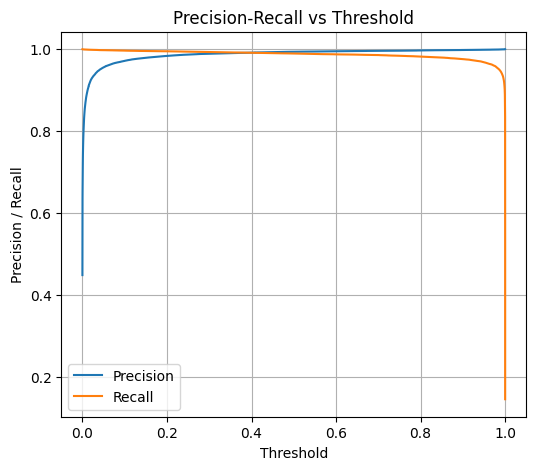

In [15]:
from sklearn.metrics import precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

labels = np.array(all_labels)
probs = np.array(all_probs)

precision, recall, thresholds = precision_recall_curve(labels, probs)

# Plot Precision-Recall
plt.figure(figsize=(6,5))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Precision / Recall")
plt.title("Precision-Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.show()


In [16]:
# -----------------------------
# Metrics
# -----------------------------
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

df_results = pd.DataFrame({
    "true_label": all_labels,
    "pred_label": all_preds,
    "confidence": all_probs
})

accuracy = accuracy_score(all_labels, all_preds)
print(f"✅ Test Accuracy: {accuracy*100:.2f}%")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=ds["train"].features["label"].names, digits=3))

cm = confusion_matrix(all_labels, all_preds)
print("\nConfusion Matrix:")
print(cm)

✅ Test Accuracy: 99.26%

Classification Report:
              precision    recall  f1-score   support

       other      0.992     0.995     0.993     38272
       drone      0.994     0.990     0.992     31134

    accuracy                          0.993     69406
   macro avg      0.993     0.992     0.992     69406
weighted avg      0.993     0.993     0.993     69406


Confusion Matrix:
[[38080   192]
 [  325 30809]]


In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
def infer_from_dataset_binary(model, dataset, threshold=0.5, drone_only=False, other_only=False):
    results = []

    test_dataset_labels = dataset.features["label"].names
    training_labels = ds["train"].features["label"].names

    for item in tqdm(dataset, desc="Inference"):
        if test_dataset_labels[item["label"]] != "drone" and drone_only:
            continue
        if test_dataset_labels[item["label"]] != "other" and other_only:
            continue

        waveform = torch.tensor(item["audio"]["array"]).float()
        if waveform.ndim > 1:
            waveform = waveform.mean(dim=0)

        # Compute Mel + dB on the fly
        mel = mel_transform(waveform)
        mel_db = db_transform(mel).unsqueeze(0).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            logits = model(mel_db)
            prob = torch.sigmoid(logits).item()
            pred_label = training_labels[1] if prob > threshold else training_labels[0]

        true_label = test_dataset_labels[item["label"]]

        results.append({
            "true_label": true_label,
            "pred_label": pred_label,
            "confidence": round(prob, 3)
        })

    df_results = pd.DataFrame(results)
    accuracy = (df_results["true_label"] == df_results["pred_label"]).mean()
    print(f"\n✅ Accuracy on ds_test_online: {accuracy*100:.2f}% {'(Drone only)' if drone_only else ''}")

    # Confusion Matrix
    labels = sorted(df_results["true_label"].unique())
    cm = confusion_matrix(df_results["true_label"], df_results["pred_label"], labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

    return df_results

Inference: 100%|██████████| 893/893 [00:02<00:00, 417.47it/s]


✅ Accuracy on ds_test_online: 65.51% 


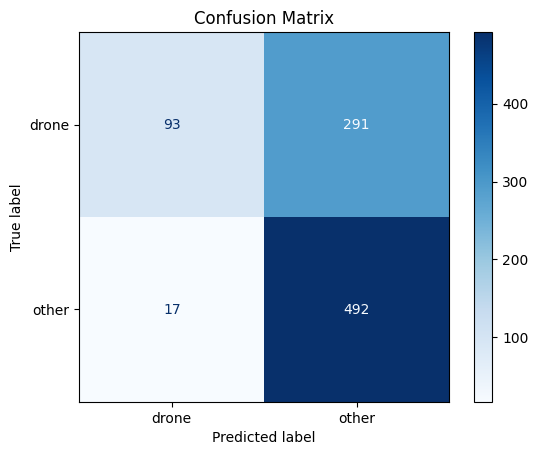

In [18]:
ds_test_online = load_dataset("Usernameeeeee/drone_test", split="test")
df_test_results = infer_from_dataset_binary(model, ds_test_online, drone_only=False)

Inference: 100%|██████████| 2805/2805 [00:05<00:00, 523.52it/s]



✅ Accuracy on ds_test_online: 25.67% 


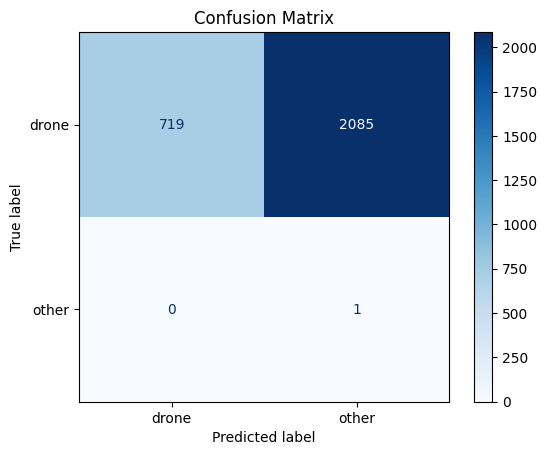

In [19]:
ds_test_online = load_dataset("Usernameeeeee/drone_test_2", split="test")
df_test_results = infer_from_dataset_binary(model, ds_test_online, drone_only=False)